<a href="https://colab.research.google.com/github/YuxingW/deep_learning/blob/main/hw4/part_1_mnist_classifier_with_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment
The assignment is to implement MNIST classifier fully with all the things learnt in last class with many features in numpy in a colab.

###Detail requirements

(a) The code should do mini batch gradient descent along with appropriate learning rate and pick appropriate batch size for minibatch.
<br />
(b) The code should do dropout - try various dropout rates and pick the one which works well.
<br />
(c) The code should do basic image augmentations to supplement the training data (not testing data) using keras libraries.
<br />
(d) The code should use  3 or more layers for training (not 2 as in example ) - you have to tune and pick number of neurons in your layer and number of layers
<br />
(e) The code will continue to use relu activation layer in right places like python code
<br />
(f) The code should normalize the input as discussed in the class before training (scaling the input)
<br />
(g) The code should use appropriate learning rate (try out few to find out which one works) - you can use adaptive learning rates like different learning rates per epoch or per mini batch.
<br />
(h) The code should provide appropriate metrics, visualization,  testing and training accuracy etc.,. and plot the results and confusion matrix  (this is important)
<br />
(i) The code should display top common errors like in below link.

# Data preprocessing

##Load and preprocessing mnist image dataset

In [1]:
import sys, numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

##Do image augmentations on the training data

In [2]:
from keras.preprocessing.image import ImageDataGenerator

# tmp = tmp_s.reshape(-1,28,28,1)
# tmp.shape
# plt.imshow(tmp[0][:,:,0])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rescale = 0)

In [3]:
#datagen.fit(x_train.reshape(-1,28,28,1))
train_augment = datagen.flow(x_train.reshape(-1,28,28, 1), y = y_train)

In [4]:
batch_index = 0
x_list, y_list = [], []
while batch_index <= train_augment.batch_index:
    data = train_augment.next()
    x_list.append(data[0])
    y_list.append(data[1])
    batch_index = batch_index + 1

x_augment = np.asarray(x_list).reshape(-1,28, 28)
y_augment = np.asarray(y_list).reshape(-1, )

In [5]:
# x_train, y_train = x_augment, y_augment
# y_train[0]

##Normalize data and covert labels to one hot labels
Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

In [6]:
def convert_labels(labels):
  one_hot_labels = np.zeros((len(labels),10))
  for i,l in enumerate(labels):
      one_hot_labels[i][l] = 1
  return one_hot_labels

images, labels = (x_train[0:10000].reshape(10000,28*28) / 255, y_train[0:10000])
labels = convert_labels(labels)
x, y_true = images, labels

images2, labels2 = (x_augment[10000:20000].reshape(10000,28*28) / 255, y_augment[10000:20000])
labels2 = convert_labels(labels2)
x2, y_true2 = images2, labels2

test_images, test_labels = x_test.reshape(len(x_test),28*28) / 255, y_test
test_labels = convert_labels(test_labels)
x_test, y_test = test_images, test_labels

print(f'images: {images.shape}, labels: {labels.shape}, test_images: {test_images.shape}, test_labels: {test_labels.shape}')

images: (10000, 784), labels: (10000, 10), test_images: (10000, 784), test_labels: (10000, 10)


#Model construction

##Construct neural network model with dropout rate
The model is constructed with linear->relu->relu->linear, drop out rate can be set on relu layers. <br />
Use MSE as loss function.

In [7]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [8]:
class Relu:
    def __call__(self, input_, dropout_rate=0):
        if dropout_rate > 0:
          dropout_mask = np.random.binomial(1, 1-dropout_rate, size=input_.shape)
          input_ *= dropout_mask * 2
        self.input_ = input_
        self.output = np.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      # import pdb; pdb.set_trace()
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

class Model:
  def __init__(self, input_dim, num_hidden, ouput_dim):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.relu2 = Relu()
    self.linear2 = Linear(num_hidden, ouput_dim)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    # Do the drop out on the first relu layer
    r1 = self.relu1(l1, dropout_rate=0.01)
    r2 = self.relu2(r1, dropout_rate=0)
    l2 = self.linear2(r2)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear2_gradient)
    relu1_gradient = self.relu1.backward(relu2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

In [9]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    #print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

## Tuning drop out rate result
I have tried drop rate 0.1 0.05 0.01 on both relu layers, it appears 0.01 on the first relu layer performs the best.

# Model training

##Initialize the model
The model is with 784-d input and 10-d output, 200 neurons for 2 hidden layers

In [10]:
loss = MSE()
nonlinear = Model(784, 200, 10)
x = images
y_true = labels

# do one forward propagation and verify loss function
y_pred = nonlinear(x)
print(loss(y_pred, y_true))

1.1130260647370191


## Define mini batch fit fuction

Do mini batch gradient descent along with the learning rate

In [11]:
from typing import Callable

def fit_by_batch(x: np.ndarray, y: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int, batch_size: int):
  for epoch in range(num_epochs):
    correct_cnt = 0
    for i in range(int(len(x) / batch_size)):
      batch_start, batch_end = ((i * batch_size), ((i+1)*batch_size))
      x_batch = x[batch_start: batch_end]
      y_batch = y[batch_start: batch_end]
      # forward propagation
      y_pred_batch = model(x_batch)
      loss_value = loss(y_pred_batch, y_batch)
      # backward propagation
      gradient_from_loss = loss.backward()
      model.backward(gradient_from_loss)
      # update parameters
      model.update(lr)
      for k in range(batch_size):
        correct_cnt += int(np.argmax(y_pred_batch[k:k+1]) == np.argmax(y_batch[k:k+1]))

    if epoch % 100 == 0:
      test_correct_cnt = 0
      y_pred_test = model(x_test)
      for k in range(len(y_test)):
        test_correct_cnt += int(np.argmax(y_pred_test[k:k+1]) == np.argmax(y_test[k:k+1]))
      print(f'Epoch {epoch},loss {loss_value}, correct_rate {correct_cnt/float(len(y))}, test_correct_rate {test_correct_cnt/float(len(y_test))}')


##Train the data with mini batch and learning rate
Tuning learning rate and batch size results
I have tried learning rate 0.1 0.05 0.01 and 0.001, in which 0.01 is the best in terms of converging speed and final test accuracy rate. <br />
Also, tried batch size 32 100 200, in which 100 performs best in terms of the test accuracy.

In [12]:
fit_by_batch(x, y_true, x_test, y_test, model=nonlinear, loss=loss, lr=0.01, num_epochs=500, batch_size=100)

y_pred = nonlinear(x)

Epoch 0,loss 0.0790938954795561, correct_rate 0.4984, test_correct_rate 0.6478
Epoch 100,loss 0.010856181700815365, correct_rate 0.9604, test_correct_rate 0.9339
Epoch 200,loss 0.007510213345112332, correct_rate 0.9758, test_correct_rate 0.9422
Epoch 300,loss 0.006545226123050028, correct_rate 0.9834, test_correct_rate 0.9468
Epoch 400,loss 0.005724241212327652, correct_rate 0.9871, test_correct_rate 0.9479


In [15]:
fit_by_batch(x2, y_true2, x_test, y_test, model=nonlinear, loss=loss, lr=0.01, num_epochs=500, batch_size=100)

y_pred = nonlinear(x)

Epoch 0,loss 0.03493561399069084, correct_rate 0.8535, test_correct_rate 0.9494


# Model evaluation

## Plot confusion matrix

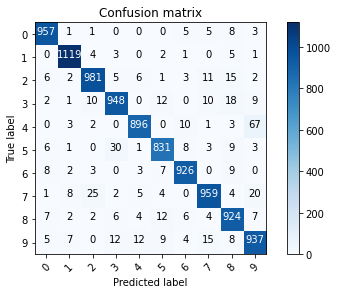

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = nonlinear(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 